In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

## 做数据可视化

In [33]:
# 数据分布分析
print(train_dataset.describe())  # 查看数值型特征的统计信息

           ps_ind_01  ps_ind_02_cat      ps_ind_03  ps_ind_04_cat  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        1.900378       1.358943       4.423318       0.416794   
std         1.983789       0.664594       2.699902       0.493311   
min         0.000000      -1.000000       0.000000      -1.000000   
25%         0.000000       1.000000       2.000000       0.000000   
50%         1.000000       1.000000       4.000000       0.000000   
75%         3.000000       2.000000       6.000000       1.000000   
max         7.000000       4.000000      11.000000       1.000000   

       ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.405188       0.393742       0.257033       0.163921   
std         1.350642       0.488579       0.436998       0.370205   
min        -1.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

<Axes: xlabel='ps_ind_01', ylabel='Count'>

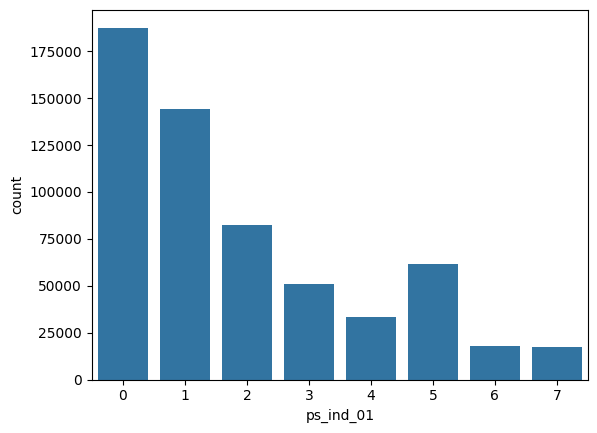

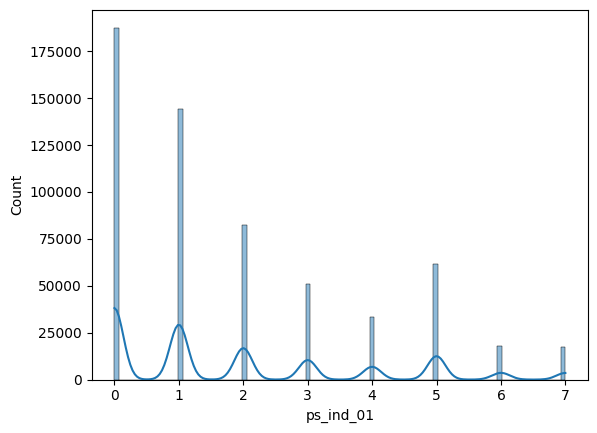

In [45]:
# 绘制数据集中各feature的分布(使用直方图、KDE(核密度估计)图等)
plt.figure()
sns.countplot(x='ps_ind_01', data=train_dataset) # 查看单个特征的分布

plt.figure()
sns.histplot(train_dataset['ps_ind_01'], kde=True)  # 查看单个特征的分布

<Axes: xlabel='ps_ind_01'>

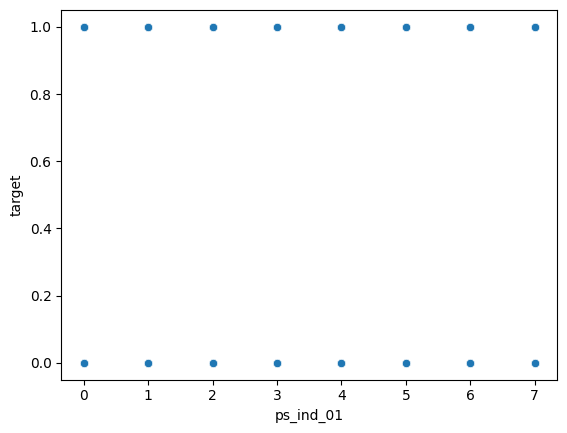

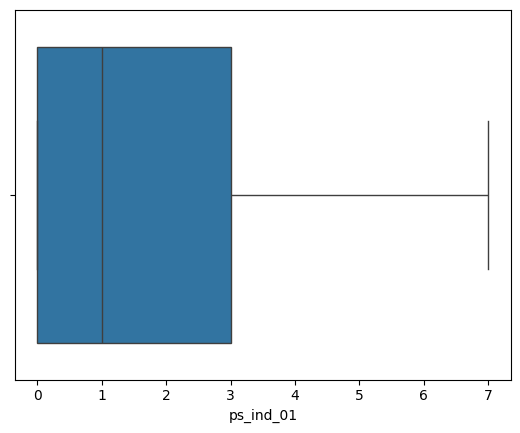

In [ ]:
# 异常值检测(使用箱线图、散点图等检测异常值(查看可能的离群点))
# 绘制特征与目标变量、特征与特征之间的散点图
plt.figure()
sns.scatterplot(x=train_dataset['ps_ind_01'], y=target) # 散点图

plt.figure()
sns.boxplot(x=train_dataset['ps_ind_01']) # 箱线图

In [ ]:
# 查看特征之间的相关性，判断多重共线性
# 计算相关性矩阵
corr = train_dataset.corr()
print(corr)

# 画相关性矩阵热力图
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
# 探索特征之间的成对关系(使用散点矩阵查看所有特征之间的散点图)
plt.figure()
sns.pairplot(train_dataset, hue='ps_ind_01', diag_kind='kde', plot_kws={'alpha': 0.5}) # hue是目标变量
plt.show()

## 做特征工程

In [ ]:
# 给特征数据添加噪声，防止过拟合
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [ ]:
# 做target_encoding
def target_encoding(trn_series=None,
                    tst_series=None,
                    tarrget=None,
                    min_samples_leaf=1,
                    smoothing=1,
                    noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = trn_series.map(averages['target']).fillna(prior)  
    ft_tst_series = tst_series.map(averages['target']).fillna(prior) 

    # ft_trn_series = pd.merge(
    #     trn_series.to_frame(trn_series.name),
    #     averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
    #     on=trn_series.name,
    #     how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # # pd.merge does not keep the index so restore it
    # ft_trn_series.index = trn_series.index
    # ft_tst_series = pd.merge(
    #     tst_series.to_frame(tst_series.name),
    #     averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
    #     on=tst_series.name,
    #     how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # # pd.merge does not keep the index so restore it
    # ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
# 对数据进行预处理

# 进行特征选择(根据variable importance)
def select_feature():
    train_features = [
        "ps_car_13",  #            : 1571.65 / shadow  609.23
        "ps_reg_03",  #            : 1408.42 / shadow  511.15
        "ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
        "ps_ind_03",  #            : 1219.47 / shadow  230.55
        "ps_ind_15",  #            :  922.18 / shadow  242.00
        "ps_reg_02",  #            :  920.65 / shadow  267.50
        "ps_car_14",  #            :  798.48 / shadow  549.58
        "ps_car_12",  #            :  731.93 / shadow  293.62
        "ps_car_01_cat",  #        :  698.07 / shadow  178.72
        "ps_car_07_cat",  #        :  694.53 / shadow   36.35
        "ps_ind_17_bin",  #        :  620.77 / shadow   23.15
        "ps_car_03_cat",  #        :  611.73 / shadow   50.67
        "ps_reg_01",  #            :  598.60 / shadow  178.57
        "ps_car_15",  #            :  593.35 / shadow  226.43
        "ps_ind_01",  #            :  547.32 / shadow  154.58
        "ps_ind_16_bin",  #        :  475.37 / shadow   34.17
        "ps_ind_07_bin",  #        :  435.28 / shadow   28.92
        "ps_car_06_cat",  #        :  398.02 / shadow  212.43
        "ps_car_04_cat",  #        :  376.87 / shadow   76.98
        "ps_ind_06_bin",  #        :  370.97 / shadow   36.13
        "ps_car_09_cat",  #        :  214.12 / shadow   81.38
        "ps_car_02_cat",  #        :  203.03 / shadow   26.67
        "ps_ind_02_cat",  #        :  189.47 / shadow   65.68
        "ps_car_11",  #            :  173.28 / shadow   76.45
        "ps_car_05_cat",  #        :  172.75 / shadow   62.92
        "ps_calc_09",  #           :  169.13 / shadow  129.72
        "ps_calc_05",  #           :  148.83 / shadow  120.68
        "ps_ind_08_bin",  #        :  140.73 / shadow   27.63
        "ps_car_08_cat",  #        :  120.87 / shadow   28.82
        "ps_ind_09_bin",  #        :  113.92 / shadow   27.05
        "ps_ind_04_cat",  #        :  107.27 / shadow   37.43
        "ps_ind_18_bin",  #        :   77.42 / shadow   25.97
        "ps_ind_12_bin",  #        :   39.67 / shadow   15.52
        "ps_ind_14",  #            :   37.37 / shadow   16.65
        "ps_car_11_cat" # Very nice spot from Tilii : https://www.kaggle.com/tilii7
    ]
    return train_features

35


In [ ]:
# 做label encoding
## 为什么要对组合特征做label encoding?
def label_encoding(train_dataset, test_dataset, train_features, combs):
    start = time.time()
    for n_c, (f1, f2) in enumerate(combs):
        name1 = f1 + "_plus_" + f2 # 为生成的新特征起名(将两个特征的名字相连)
        print('current feature %60s %4d in %5.1f'
            % (name1, n_c + 1, (time.time() - start) / 60), end='')
        print('\r' * 75, end='')
        # 向数据集中添加新的特征以及特征值
        # 特征值是由组合特征的值转为str类型后拼接起来的
        # lambda x 是一个内联的匿名函数，它通过lambda快速定义了一个函数
        train_dataset[name1] = train_dataset[f1].apply(lambda x: str(x)) + "_" + train_dataset[f2].apply(lambda x: str(x))
        test_dataset[name1] = test_dataset[f1].apply(lambda x: str(x)) + "_" + test_dataset[f2].apply(lambda x: str(x))
        # 使用LabelEncoder对新的特征进行标签编码(标签编码是字符串转换为整数标签的过程)
        lbl = LabelEncoder()
        # fit()用于训练编码器(训练集和测试集中的数据都要用上)
        lbl.fit(list(train_dataset[name1].values) + list(test_dataset[name1].values))
        # transform()用于将特征值转换为整数标签
        train_dataset[name1] = lbl.transform(list(train_dataset[name1].values))
        test_dataset[name1] = lbl.transform(list(test_dataset[name1].values))

        train_features.append(name1)

## 做数据预处理

In [ ]:
# 做上采样
def up_sampling():
    if increase:
        # Get positive examples
        pos = pd.Series(trn_tgt == 1)
        # Add positive examples
        trn_dat = pd.concat([trn_dat, trn_dat.loc[pos]], axis=0)
        trn_tgt = pd.concat([trn_tgt, trn_tgt.loc[pos]], axis=0)
        # Shuffle data
        idx = np.arange(len(trn_dat))
        np.random.shuffle(idx)
        trn_dat = trn_dat.iloc[idx]
        trn_tgt = trn_tgt.iloc[idx]

## 做模型评估

In [ ]:
# 计算gini系数
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true) # 将y_true转换为numpy数组

    # 使用np.argsort(y_prob)获取y_prob排序后的索引,然后根据这些索引对y_true进行排序
    y_true = y_true[np.argsort(y_prob)]
    
    ntrue = 0 # 累计正样本数
    gini = 0
    delta = 0 # 累计负样本数(在当前样本之前的)
    n = len(y_true)
    # 逆序遍历(因为排序顺序是按照预测概率从低到高排序，因此先获取概率高的数据)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta # (y_i * delta)表示样本i对基尼系数的贡献
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

# 计算xgb的gini系数
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = eval_gini(labels, preds)
    return [('gini', gini_score)]

In [ ]:

def evaluate():
    # Compute mean score and std
    mean_eval = np.mean(xgb_evals, axis=1)
    std_eval = np.std(xgb_evals, axis=1)
    best_round = np.argsort(mean_eval)[::-1][0]

    print("Best mean score : %.6f + %.6f @%4d"
        % (mean_eval[best_round], std_eval[best_round], best_round))
        
    importances = sorted([(trn_df.columns[i], imp) for i, imp in enumerate(imp_df.mean(axis=1))],
                        key=lambda x: x[1])

    for f, imp in importances[::-1]:
        print("%-34s : %10.4f" % (f, imp))

## 整体流程

In [ ]:
# 读取数据集(对某些数据集考虑使用data_loader读取)
train_dataset = pd.read_csv("../data/train.csv", index_col=0)
test_dataset = pd.read_csv("../data/test.csv", index_col=0)

feature_names = train_dataset.columns[1:]
target = train_dataset["target"]

train_dataset = train_dataset.iloc[:, 1:] # 去掉target列，只留下features的部分
test_dataset = test_dataset.iloc[:, 1:]

# 做数据分析和预处理(调用可视化函数、数据清洗与填充等)
## 查看数据的基本信息(维度、前5行、数据类型等)
print(train_dataset.shape)
print(target.shape)
print(len(feature_names)) # 特征数量

print(train_dataset.head()) # 查看数据的前5行
print(train_dataset.info()) # 查看数据类型

## 检查数据是否有缺失值并决定如何处理(删除、填充、插值等)
print(train_dataset.isnull().sum())

## 填充缺失值：使用均值、中位数、众数或更复杂的插值方法

In [ ]:
# 做特征工程
## 做特征选择
train_features = select_feature()
print(len(train_features))

## 做特征组合
### 为什么对这些特征进行组合？是因为两者相似度高吗？
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

## 做label encoding
label_encoding(combs)

## 获得做特征工程后的数据集
train_dataset = train_dataset[train_features]
test_dataset = test_dataset[test_dataset]

In [ ]:
# 设定参数
n_splits = 5
n_estimators = 200
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=15) 
imp_df = np.zeros((len(trn_df.columns), n_splits))
xgb_evals = np.zeros((n_estimators, n_splits))
oof = np.empty(len(trn_df))
sub_preds = np.zeros(len(sub_df))
increase = True
np.random.seed(0)

In [ ]:
# k-folds 训练
for fold_, (trn_idx, val_idx) in enumerate(folds.split(target, target)):
    trn_dat, trn_tgt = trn_df.iloc[trn_idx], target.iloc[trn_idx]
    val_dat, val_tgt = trn_df.iloc[val_idx], target.iloc[val_idx]

    clf = XGBClassifier(n_estimators=n_estimators,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=.1, 
                        subsample=.8, 
                        colsample_bytree=.8,
                        gamma=1,
                        reg_alpha=0,
                        reg_lambda=1,
                        nthread=2)
    # Upsample during cross validation to avoid having the same samples
    # in both train and validation sets
    # Validation set is not up-sampled to monitor overfitting
    up_sampling()
        
    clf.fit(trn_dat, trn_tgt, 
            eval_set=[(trn_dat, trn_tgt), (val_dat, val_tgt)],
            eval_metric=gini_xgb,
            early_stopping_rounds=None,
            verbose=False)
            
    # Keep feature importances
    imp_df[:, fold_] = clf.feature_importances_

    # Find best round for validation set
    xgb_evals[:, fold_] = clf.evals_result_["validation_1"]["gini"]
    # Xgboost provides best round starting from 0 so it has to be incremented
    best_round = np.argsort(xgb_evals[:, fold_])[::-1][0]

    # Predict OOF and submission probas with the best round
    oof[val_idx] = clf.predict_proba(val_dat, ntree_limit=best_round)[:, 1]
    # Update submission
    sub_preds += clf.predict_proba(sub_df, ntree_limit=best_round)[:, 1] / n_splits

    # Display results
    print("Fold %2d : %.6f @%4d / best score is %.6f @%4d"
        % (fold_ + 1,
            eval_gini(val_tgt, oof[val_idx]),
            n_estimators,
            xgb_evals[best_round, fold_],
            best_round))
        
print("Full OOF score : %.6f" % eval_gini(target, oof))

In [ ]:
# 保存预测结果(将结果存入csv文件中)
sub_df["target"] = sub_preds
sub_df[["target"]].to_csv("submission.csv", index=True, float_format="%.9f")